# CS 585 HW 1

**Due:** 11:59 PM (at midnight) EST, Wednesday, February 14, 2024

**Completed By:**
* Muhammad Aseef Imran
* Munir Siddiqui

In [1]:
# imports
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import math
from typing import Any
from numpy import ndarray, dtype, generic
from cv2 import Mat, UMat
from cv2 import VideoCapture

In [2]:
webcam = cv.VideoCapture(0)

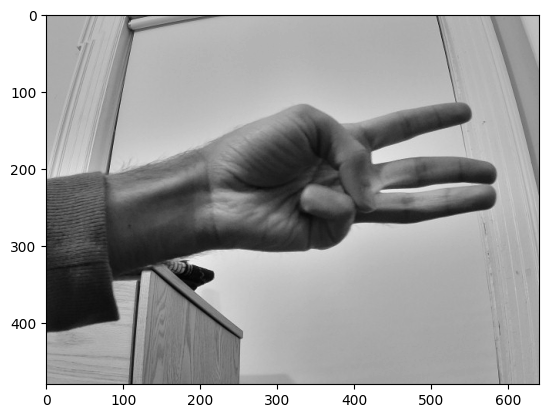

In [36]:
success, frame = webcam.read()
if success:
    grayscale = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    plt.imshow(grayscale, cmap='gray')
    plt.plot()

In [3]:
from cv2.gapi.wip.draw import Image


def plt_show_img(name: str, img: Image):
    # plt.imshow(img)
    # plt.plot()
    cv.namedWindow(name, cv.WINDOW_AUTOSIZE)
    cv.imshow(name, img)
    #cv.waitKey(0)

In [4]:
def rescaleFrame(frame: Mat | ndarray[Any, dtype[generic]] | ndarray, scale) -> UMat:
    height = int(frame.shape[0] * scale)
    width = int(frame.shape[1] * scale)
    return cv.resize(frame, (width, height), interpolation=cv.INTER_AREA)

In [5]:
def setResLiveVideo(frame: VideoCapture, width: int):
    # given the width we automatically figure out the height
    scale = width / frame.get(3)
    height = int(frame.get(4) * scale)
    webcam.set(3, width)
    webcam.set(4, height)

In [6]:
# rescale frame for faster computation
setResLiveVideo(webcam, 400)

In [7]:
def calc_area(img: np.ndarray):
    return np.count_nonzero(img)

In [8]:
def find_centroid(img: np.ndarray):
    area = calc_area(img)
    # calculate the first moment
    # m10 = 0
    # m01 = 0
    # for i in range(img.shape[0]):
    #     for j in range(img.shape[1]):
    #         if img[i, j] > 0:
    #             m10 += i
    #             m01 += j
    # above code works, but numpy is faster!
    m10 = np.sum(np.where(img > 0)[0])
    m01 = np.sum(np.where(img > 0)[1])

    # calculate the centroid
    x = m10 / area
    y = m01 / area
    return (x, y)

In [9]:
def find_axis_of_least_inertia(img: np.ndarray):
    # calc first moments
    x, y = find_centroid(img)
    # calculate the second moments
    # m11 = 0
    # m20 = 0
    # m02 = 0
    # for i in range(img.shape[0]):
    #     for j in range(img.shape[1]):
    #         if img[i, j] > 0:
    #             m11 += (i - x) * (j - y)
    #             m20 += (i - x) ** 2
    #             m02 += (j - y) ** 2

    # does the same thing as above but numpy is faster so..
    m11 = np.sum((np.where(img > 0)[0] - x) * (np.where(img > 0)[1] - y))
    m20 = np.sum((np.where(img > 0)[0] - x) ** 2)
    m02 = np.sum((np.where(img > 0)[1] - y) ** 2)

    # calculate the angle of least inertia
    theta = 0.5 * np.arctan2(2 * m11, m20 - m02)
    # draw the angle line with midpoint at centroid
    x1 = int(x + 100 * np.cos(theta))
    y1 = int(y + 100 * np.sin(theta))
    x2 = int(x - 100 * np.cos(theta))
    y2 = int(y - 100 * np.sin(theta))

    img = cv.cvtColor(img, cv.COLOR_GRAY2RGB)
    img = cv.line(img, (y1, x1), (y2, x2), (0, 255, 0), 2)
    cv.putText(img, f'{theta}', (10, 30), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv.LINE_AA)
    plt_show_img("Angle of Least Inertia", img)

    print(f'Angle of least inertia: {theta} {math.degrees(theta)}')
    return (x, y), (theta)

In [10]:
while True:
    success, frame = webcam.read()
    if not success:
        print('Failed to capture frame')
        break

    plt_show_img("Original", frame)

    # convert the video frame into a binary image
    # so that all pixels that look like skin color
    # are included in the binary object
    hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
    ycrcb = cv.cvtColor(frame, cv.COLOR_BGR2YCrCb)

    # Define the thresholds for HSV color space
    lower_hsv = np.array([0, 15, 0], dtype=np.uint8)
    upper_hsv = np.array([17, 170, 255], dtype=np.uint8)

    # Define the thresholds for YCrCb color space
    lower_ycrcb = np.array([0, 135, 85], dtype=np.uint8)
    upper_ycrcb = np.array([255, 180, 135], dtype=np.uint8)

    # Create masks for each color space
    mask_hsv = cv.inRange(hsv, lower_hsv, upper_hsv)
    mask_ycrcb = cv.inRange(ycrcb, lower_ycrcb, upper_ycrcb)

    # Combine the masks
    mask_combined = cv.bitwise_and(mask_hsv, mask_ycrcb)

    # Apply the combined mask to the original frame
    frame = cv.bitwise_and(frame, frame, mask=mask_combined)

    # Display the masked video
    plt_show_img("Masked", frame)

    # smooth out the image via median blur (take the median of surrounding pixels)
    # effective for removing the noise
    frame = cv.medianBlur(frame,13)

    #cv.imshow('Video 1', frame)

    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    _, thres_output = cv.threshold(gray, 20, 255, cv.THRESH_BINARY)

    # find largest object in the binary image
    contours, _ = cv.findContours(thres_output, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=lambda x: cv.contourArea(x), reverse=True)

    if len(contours) == 0:
        continue

    # draw the largest object
    if len(contours) > 0:
        x, y, w, h = cv.boundingRect(contours[0])
        thres_output = cv.rectangle(thres_output, (x, y), (x+w, y+h), (0, 255, 0), 4)

    # get rid of everything except the largest object
    mask = np.zeros(thres_output.shape, dtype=np.uint8)
    cv.drawContours(mask, contours, 0, (255, 255, 255), -1)
    thres_output = cv.bitwise_and(thres_output, mask)
    # fill holes in the contour
    cv.fillPoly(thres_output, pts =[contours[0]], color=(255,255,255))

    centroid, theta = find_axis_of_least_inertia(thres_output)

    # rotate such that the line of least inertia is horizontally flat
    (rows, cols) = thres_output.shape
    M = cv.getRotationMatrix2D((centroid[0], centroid[1]), -math.degrees(theta), 1)
    img = cv.warpAffine(thres_output, M, (cols, rows))
    plt_show_img("Post rotation", img)

    if cv.waitKey(20) & 0xFF==ord('d'):
        break

Angle of least inertia: 1.4629508056561698 83.82090679936205
Angle of least inertia: 0.8968545529942479 51.385980723662435
Angle of least inertia: 1.2055569622860796 69.07332590160452
Angle of least inertia: 0.9478310666760732 54.30671981192192
Angle of least inertia: 1.2988586475354025 74.41911868784872
Angle of least inertia: 1.301804903847364 74.5879267398879
Angle of least inertia: 1.3351503467047314 76.49847988160971
Angle of least inertia: 1.3278879895326017 76.08237746633012
Angle of least inertia: 1.315818068907559 75.39082195545726
Angle of least inertia: 1.3351579301515002 76.49891438110373
Angle of least inertia: 1.3241577984749064 75.86865326194673
Angle of least inertia: 1.2770472999282705 73.1694205244673
Angle of least inertia: 1.2770472999282705 73.1694205244673
Angle of least inertia: 1.3145763595873317 75.31967725202618
Angle of least inertia: 1.2891038285411986 73.86020872956679
Angle of least inertia: 1.3057282615498826 74.81271857776237
Angle of least inertia: 1.31

KeyboardInterrupt: 

Angle of least inertia: -1.3164344228159177 -75.42613643309261


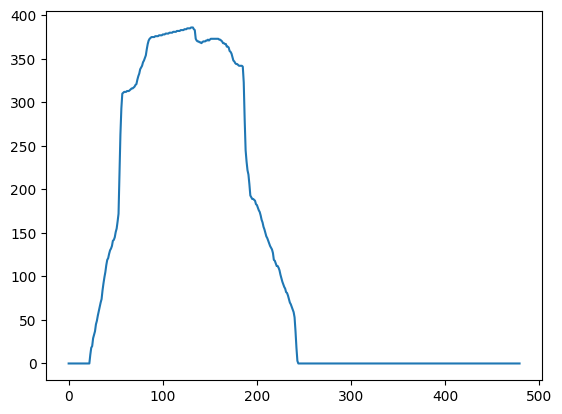

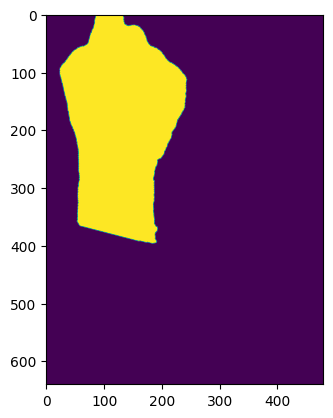

Angle of least inertia: -1.2814991814478625 -73.4244945464322


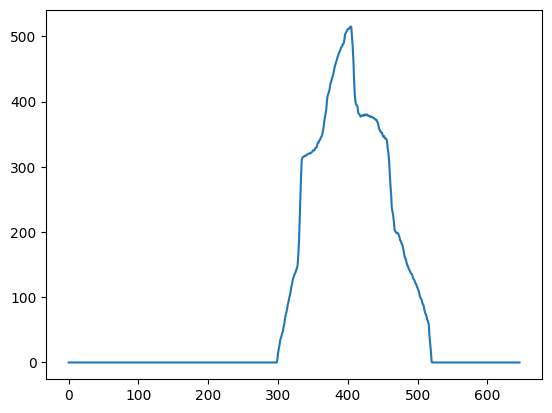

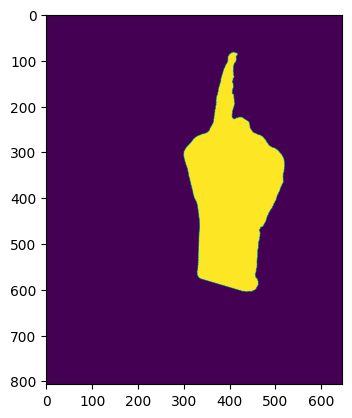

Angle of least inertia: -1.3520550901406632 -77.46705033424008


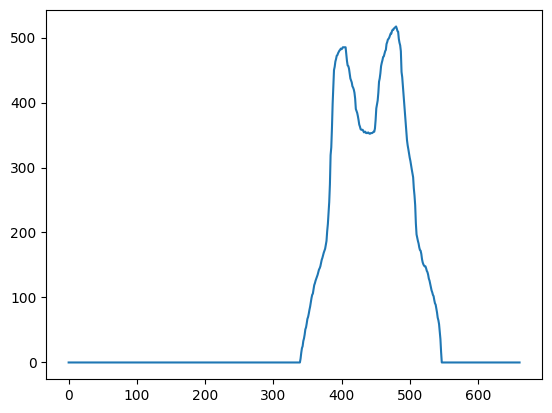

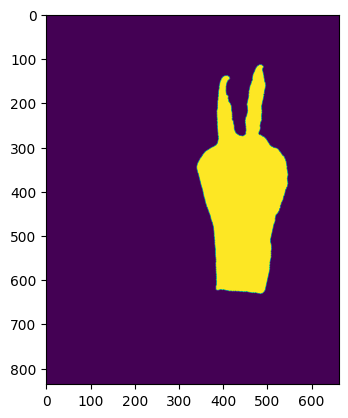

Angle of least inertia: -1.4140726502974736 -81.02039478692402


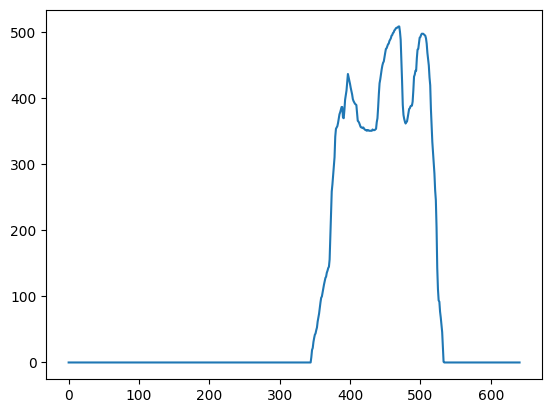

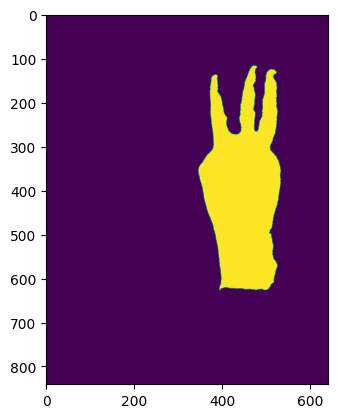

Angle of least inertia: -1.4870696585722207 -85.20281527814856


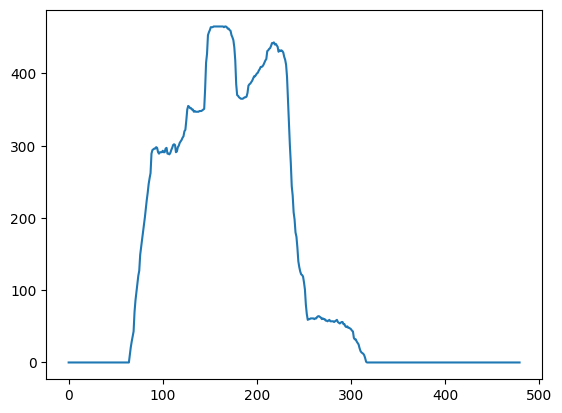

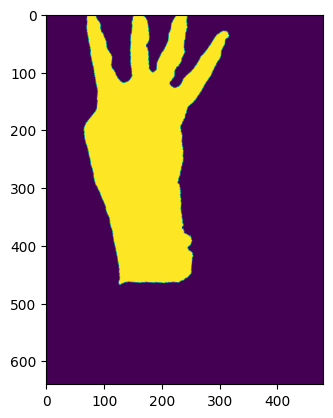

Angle of least inertia: -1.5239529644019505 -87.31607303668235


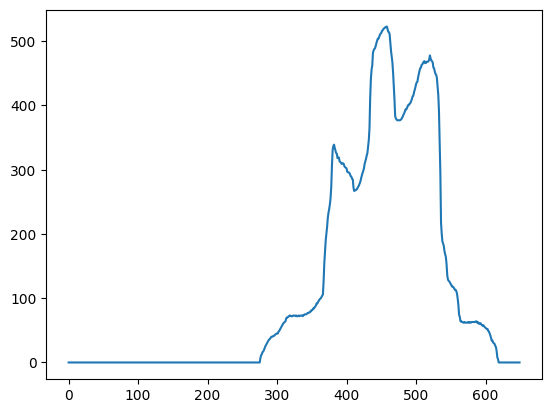

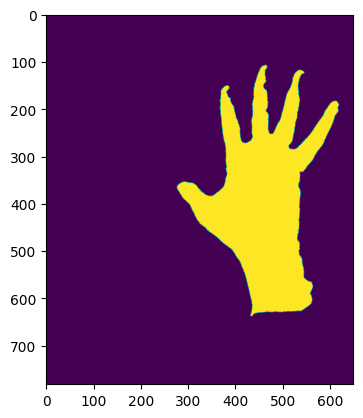

In [11]:
# for i in range(0, 6):
#     frame = cv.imread(f"{i}-fingers.png")
#
#     plt_show_img("Original", frame)
#
#     # convert the video frame into a binary image
#     # so that all pixels that look like skin color
#     # are included in the binary object
#     hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
#     ycrcb = cv.cvtColor(frame, cv.COLOR_BGR2YCrCb)
#
#     # Define the thresholds for HSV color space
#     lower_hsv = np.array([0, 15, 0], dtype=np.uint8)
#     upper_hsv = np.array([17, 170, 255], dtype=np.uint8)
#
#     # Define the thresholds for YCrCb color space
#     lower_ycrcb = np.array([0, 135, 85], dtype=np.uint8)
#     upper_ycrcb = np.array([255, 180, 135], dtype=np.uint8)
#
#     # Create masks for each color space
#     mask_hsv = cv.inRange(hsv, lower_hsv, upper_hsv)
#     mask_ycrcb = cv.inRange(ycrcb, lower_ycrcb, upper_ycrcb)
#
#     # Combine the masks
#     mask_combined = cv.bitwise_and(mask_hsv, mask_ycrcb)
#
#     # Apply the combined mask to the original frame
#     frame = cv.bitwise_and(frame, frame, mask=mask_combined)
#
#     # Display the masked video
#     plt_show_img("Masked", frame)
#
#     # smooth out the image via median blur (take the median of surrounding pixels)
#     # effective for removing the noise
#     frame = cv.medianBlur(frame,13)
#
#     #cv.imshow('Video 1', frame)
#
#     gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
#     _, thres_output = cv.threshold(gray, 20, 255, cv.THRESH_BINARY)
#
#     # find largest object in the binary image
#     contours, _ = cv.findContours(thres_output, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
#     contours = sorted(contours, key=lambda x: cv.contourArea(x), reverse=True)
#
#
#     # draw the largest object
#     if len(contours) > 0:
#         x, y, w, h = cv.boundingRect(contours[0])
#         thres_output = cv.rectangle(thres_output, (x, y), (x+w, y+h), (0, 255, 0), 4)
#
#     # get rid of everything except the largest object
#     mask = np.zeros(thres_output.shape, dtype=np.uint8)
#     cv.drawContours(mask, contours, 0, (255, 255, 255), -1)
#     thres_output = cv.bitwise_and(thres_output, mask)
#     # fill holes in the contour
#     cv.fillPoly(thres_output, pts =[contours[0]], color=(255,255,255))
#
#     centroid, theta = find_axis_of_least_inertia(thres_output)
#
#     # rotate such that the line of least inertia is horizontally flat
#     (rows, cols) = thres_output.shape
#     M = cv.getRotationMatrix2D((centroid[0], centroid[1]), -math.degrees(theta), 1)
#     img = cv.warpAffine(thres_output, M, (rows, cols))
#     plt_show_img("Post rotation", img)
#
#     # make a histogram of the x positions of the binary image and plot it
#
#     # first use np to make the bins
#     bins = np.arange(0, img.shape[1], 1)
#     # then use np to make the histogram
#     hist = np.histogram(np.where(img > 0)[1], bins=range(img.shape[1] + 1))
#     # then plot the histogram
#     plt.figure()
#     plt.plot(hist[0])
#     plt.show()
#
#     plt.imshow(img)
#     plt.show()
